# Sanity Check: Check confusion matrices of the best performing models

Let's look at them closely, particularly at their confusion matrix for each label and do a sanity check of their current performance for the labels

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [1]:
import os

import spacy
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from xgboost import XGBClassifier


from preprocessing.InputDataset import FramingArticleDataset
from preprocessing.BOWPipeline import basic_tokenizing_and_cleaning, BOWPipeline
from training.MultiLabelEstimator import MultiLabelEstimator
from benchmark_subtask_2 import LABELS, SPACY_MODELS

/home/juanbermeo/anaconda3/envs/Framing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/juanbermeo/anaconda3/envs/Framing/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/juanbermeo/anaconda3/envs/Framing/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas imp

The best performing models with default parameters are:

  * English: RandomForest, RidgecClassifier, LinearSVC, and SVC
  * Italian: LogisticRegression, RandomForest, XGBoost, LinearSVC
  * French: XGBoost, LinearSVC, LogisticRegression
  * Polish: LogisticRegression, RandomForest, LinearSVC
  * Russian: XGBoost, LinearSVC, LogisticRegression
  * German: LogisticRegression, LinearSVC, RidgecClassifier

In [9]:
def get_confusion_matrices(models, n_splits=3):
    cm_matrices = {}
    mlb = MultiLabelBinarizer()
    mlb.fit([LABELS])

    ordered_labels = mlb.classes_
    num_samples_test = {}
    for language, best_model_tuple in models.items():
        cm_matrices[language] = {}
        language_str = f"Processing language: {language}"
        print(language_str)
        print('#' * len(language_str) + '\n' + '#' * len(language_str))
        train_data = FramingArticleDataset(
                data_dir=data_dir,
                language=language,
                subtask=2,
                split='train',
                load_preprocessed_units_of_analysis=True,
                units_of_analysis_dir=os.path.join(data_dir, 'preprocessed')
        )

        X, y = train_data.df.raw_text, train_data.df.frames
        X = X.to_numpy()
        y = mlb.transform(y.str.lower().str.split(','))

        # Split data using stratified sampling of the labels
        mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
        train_idx, test_idx = next(mskf.split(X, y))
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        num_samples_test[language] = y_test.shape[0]

        # Define vectorizing pipeline
        nlp = spacy.load(SPACY_MODELS[language]['small'])
        vectorizing_pipeline = BOWPipeline(
                tokenizer=lambda string: basic_tokenizing_and_cleaning(string, spacy_nlp_model=nlp),
                use_tfidf=True,
                min_df=0.05,
                max_df=0.95,
                max_features=10000,
                ngram_range=(1, 1),
                min_var=0.001,
                corr_threshold=0.9
            )

        # Vectorize the strings
        X_train = vectorizing_pipeline.pipeline.fit_transform(X_train)
        X_test = vectorizing_pipeline.pipeline.transform(X_test)

        # Initiliaze, fit model and get confusion matrices
        for model in best_model_tuple:
            print('\t' + model.__class__.__name__)
            print('\t' + len(model.__class__.__name__)*'-')
            multilabel_cls = MultiLabelEstimator(
                        base_estimator=model,
                        base_estimator_hyperparam_dist=dict(),
                        treat_labels_as_independent=True,
                        scoring_functions=('f1_micro',)
                    )
            # Fit model
            multilabel_cls.multi_label_estimator.fit(X_train, y_train)

            # Get predictions on train and test
            y_train_pred = multilabel_cls.multi_label_estimator.predict(X_train)
            y_test_pred = multilabel_cls.multi_label_estimator.predict(X_test)

            # Print performance f1-score in train and test
            print(f"\t\t f1-score on train: {f1_score(y_true=y_train, y_pred=y_train_pred, average='micro'):.03f}")
            print(f"\t\t f1-score on test: {f1_score(y_true=y_test, y_pred=y_test_pred, average='micro'):.03f}")

            # Store confusion matrices
            cm_matrices[language][model.__class__.__name__] = multilabel_confusion_matrix(y_true=y_test, y_pred=y_test_pred)

        print('\n\n')

    return ordered_labels, num_samples_test, cm_matrices


def print_confusion_matrices(confusion_matrices, ordered_labels):
    for idx, label in enumerate(ordered_labels):
        print(label)
        print(confusion_matrices[idx, :, :])
        print('\n')


def plot_cms_multiple_models(confusion_matrices_various_models, ordered_labels, v_max, font_size=22, figsize=(14,3.5)):
    plt.rcParams.update({
        'font.size': font_size,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot multilabel confusion matrices side by side for all models
    num_models = len(confusion_matrices_various_models)

    for label_id, label in enumerate(ordered_labels):
        fig, axes = plt.subplots(1, num_models, figsize=figsize)
        fig.suptitle(label, fontsize=20)

        for i, ((model_name, confusion_matrices), ax_) in enumerate(zip(confusion_matrices_various_models.items(), axes)):
            cm_plot = ConfusionMatrixDisplay(confusion_matrices[label_id, :, :])
            if i == num_models - 1:
                cm_plot.plot(cmap='Blues', ax=ax_, colorbar=True, im_kw={'vmin':0, 'vmax':v_max})
            else:
                cm_plot.plot(cmap='Blues', ax=ax_, colorbar=False, im_kw={'vmin':0, 'vmax':v_max})
            ax_.set_title(model_name)


        plt.show()

        print('\n\n')

# Train the best performing models on a stratified train/test split

Also check the difference between train and test

In [3]:
data_dir = os.path.join('..', '..' ,'..', 'data')
models = {
    'en': (RandomForestClassifier(), RidgeClassifier(), LinearSVC(), SVC()),
    'it': (LogisticRegression(penalty='none'), RandomForestClassifier(), XGBClassifier(verbosity=0, silent=True) , LinearSVC()),
    'fr': (XGBClassifier(verbosity=0, silent=True), LinearSVC(), LogisticRegression(penalty='none')),
    'po': (LogisticRegression(penalty='none'), RandomForestClassifier(), LinearSVC()),
    'ru': (XGBClassifier(verbosity=0, silent=True), LinearSVC(), LogisticRegression(penalty='none')),
    'ge': (LogisticRegression(penalty='none'), LinearSVC(), RidgeClassifier()),
}

In [8]:
ordered_labels_, num_samples_test_, cm_matrices_ = get_confusion_matrices(models=models, n_splits=3)

Processing language: en
#######################
#######################


433it [00:00, 26286.87it/s]


	RandomForestClassifier
	----------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.670
	RidgeClassifier
	---------------
		 f1-score on train: 0.782
		 f1-score on test: 0.654
	LinearSVC
	---------
		 f1-score on train: 0.843
		 f1-score on test: 0.660
	SVC
	---
		 f1-score on train: 0.834
		 f1-score on test: 0.651



Processing language: it
#######################
#######################


227it [00:00, 14899.02it/s]


	LogisticRegression
	------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.484
	RandomForestClassifier
	----------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.457
	XGBClassifier
	-------------
		 f1-score on train: 1.000
		 f1-score on test: 0.444
	LinearSVC
	---------
		 f1-score on train: 0.888
		 f1-score on test: 0.481



Processing language: fr
#######################
#######################


158it [00:00, 6993.53it/s]


	XGBClassifier
	-------------
		 f1-score on train: 1.000
		 f1-score on test: 0.441
	LinearSVC
	---------
		 f1-score on train: 0.916
		 f1-score on test: 0.419
	LogisticRegression
	------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.432



Processing language: po
#######################
#######################


145it [00:00, 8988.81it/s]


	LogisticRegression
	------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.616
	RandomForestClassifier
	----------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.599
	LinearSVC
	---------
		 f1-score on train: 0.922
		 f1-score on test: 0.587



Processing language: ru
#######################
#######################


143it [00:00, 23670.45it/s]


	XGBClassifier
	-------------
		 f1-score on train: 1.000
		 f1-score on test: 0.417
	LinearSVC
	---------
		 f1-score on train: 0.883
		 f1-score on test: 0.333
	LogisticRegression
	------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.428



Processing language: ge
#######################
#######################


132it [00:00, 22153.01it/s]


	LogisticRegression
	------------------
		 f1-score on train: 1.000
		 f1-score on test: 0.544
	LinearSVC
	---------
		 f1-score on train: 0.985
		 f1-score on test: 0.536
	RidgeClassifier
	---------------
		 f1-score on train: 0.872
		 f1-score on test: 0.534





# Check confusions matrices in the dataset of a language for the set of models trained

For example for the english dataset, we can see that for this dataset LinearSVC is better at predicting minority classes than RandomForest.

We can also see that the models are not overfitting so strongly that they **only** predict the majority classes. However, while they are not just predicting the majority, there is much room for improvement in the prediction of the minority classes

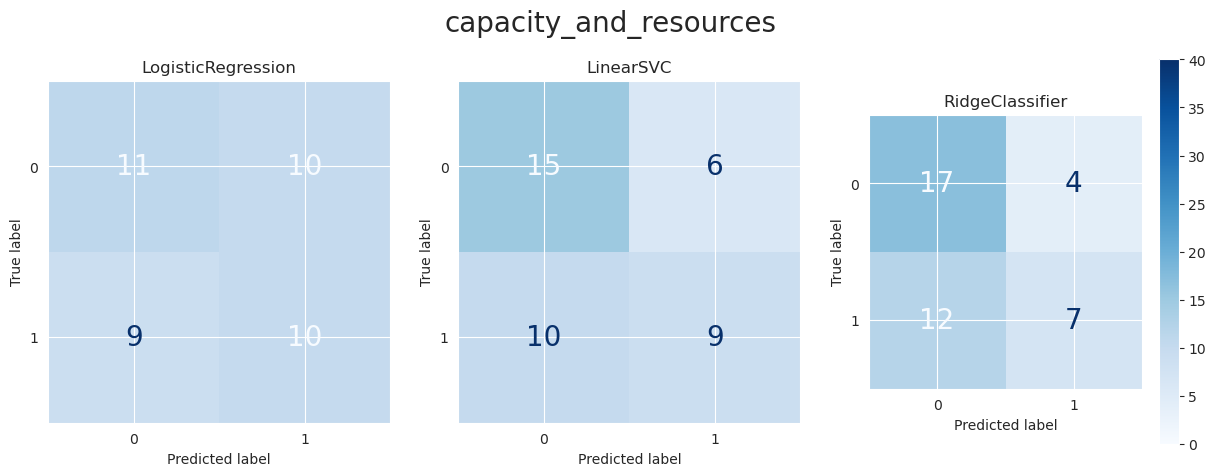

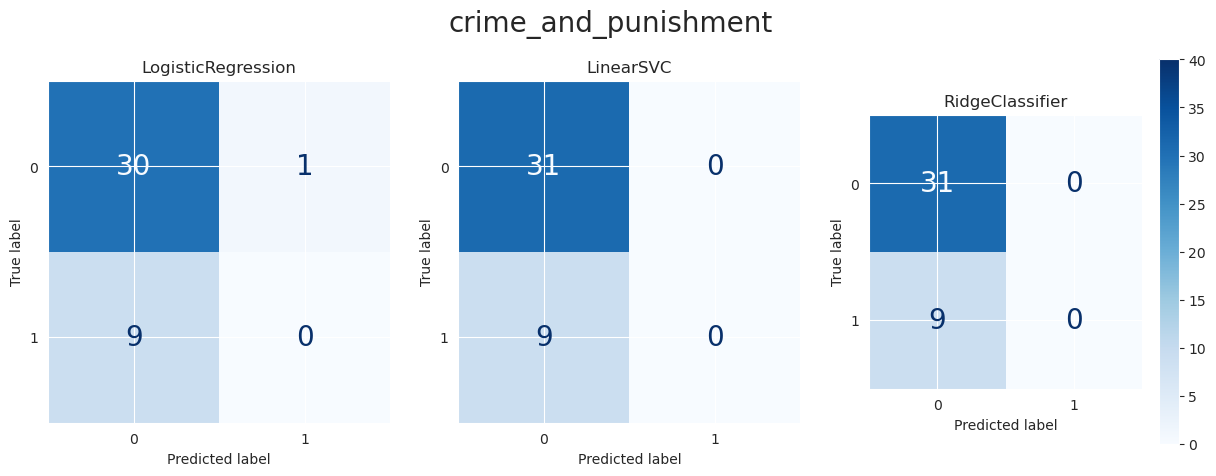

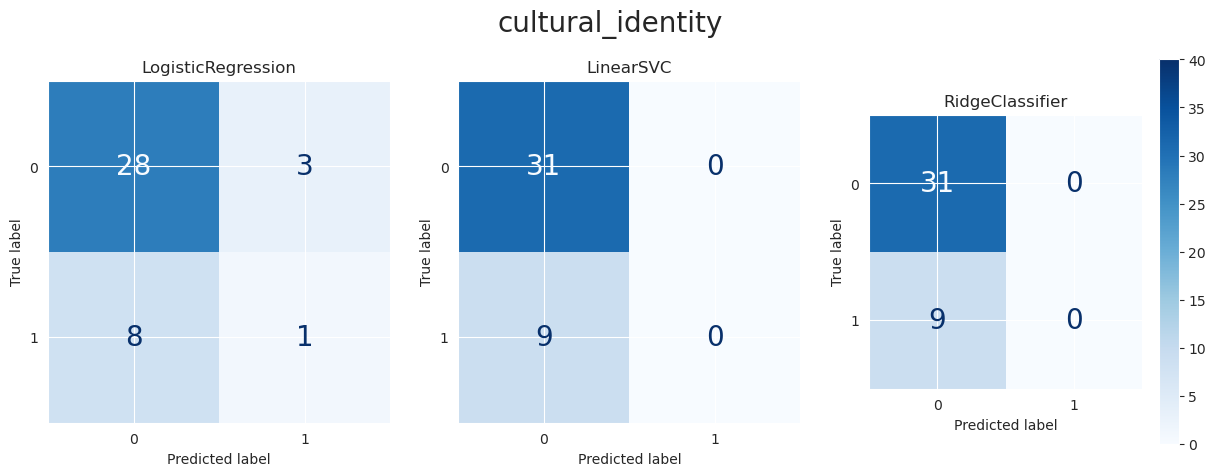

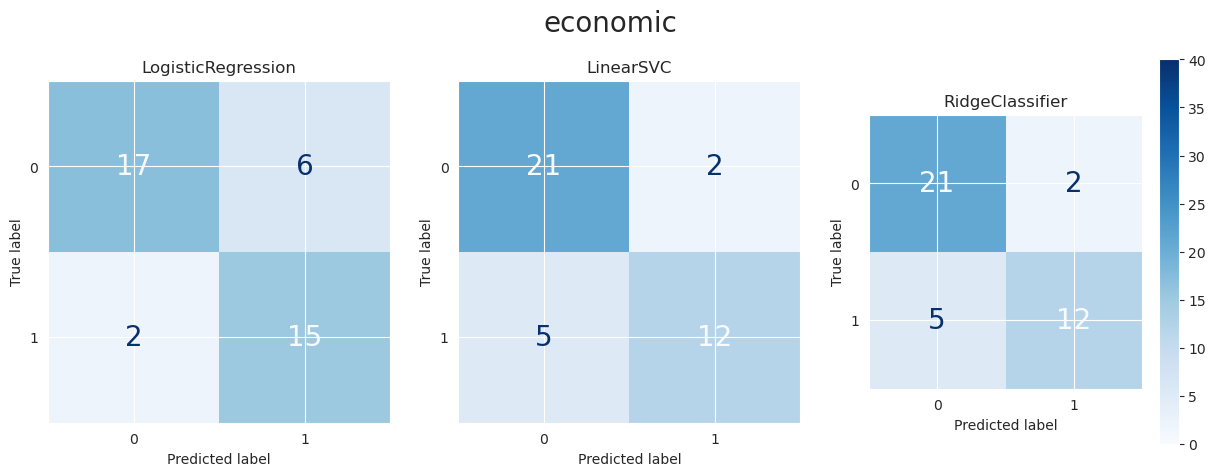

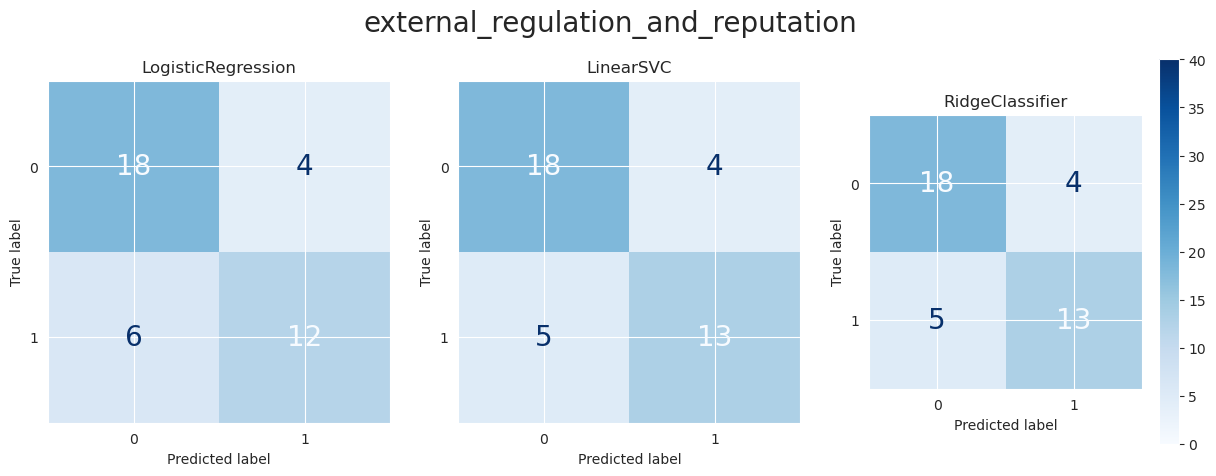

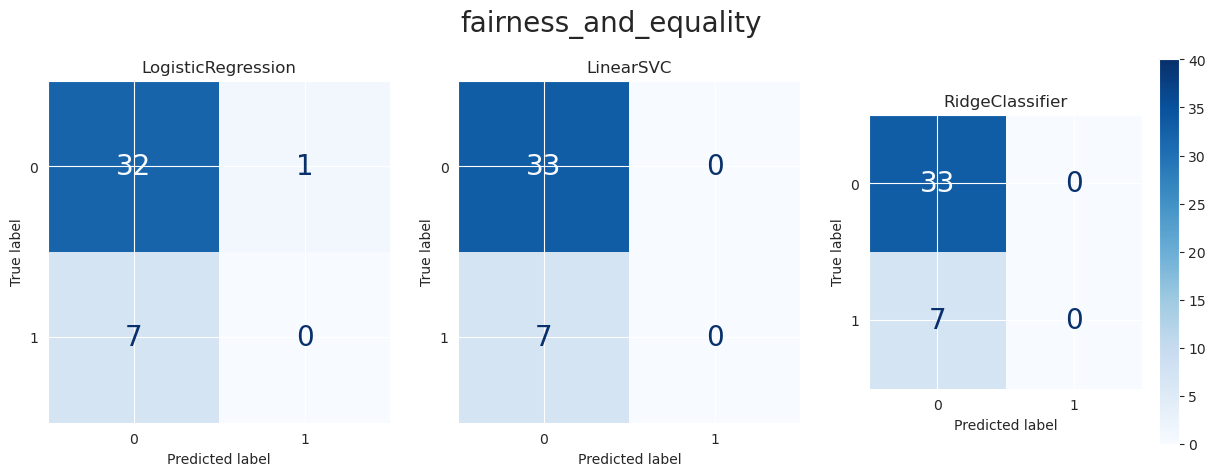

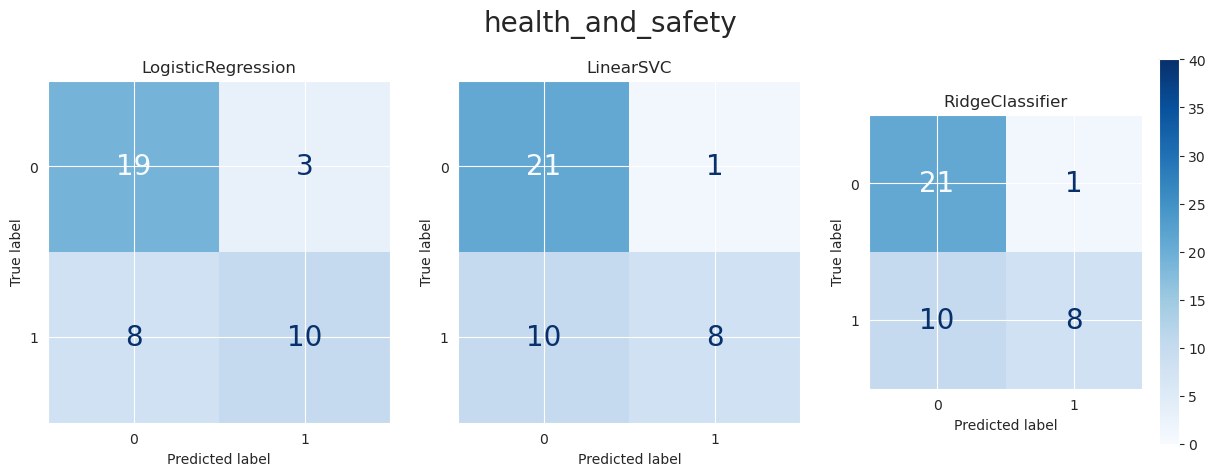

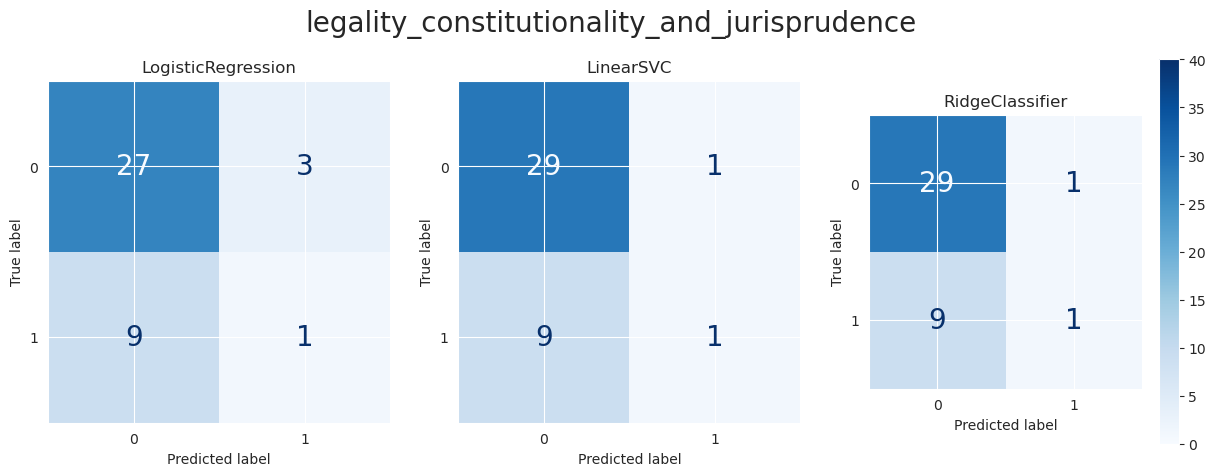

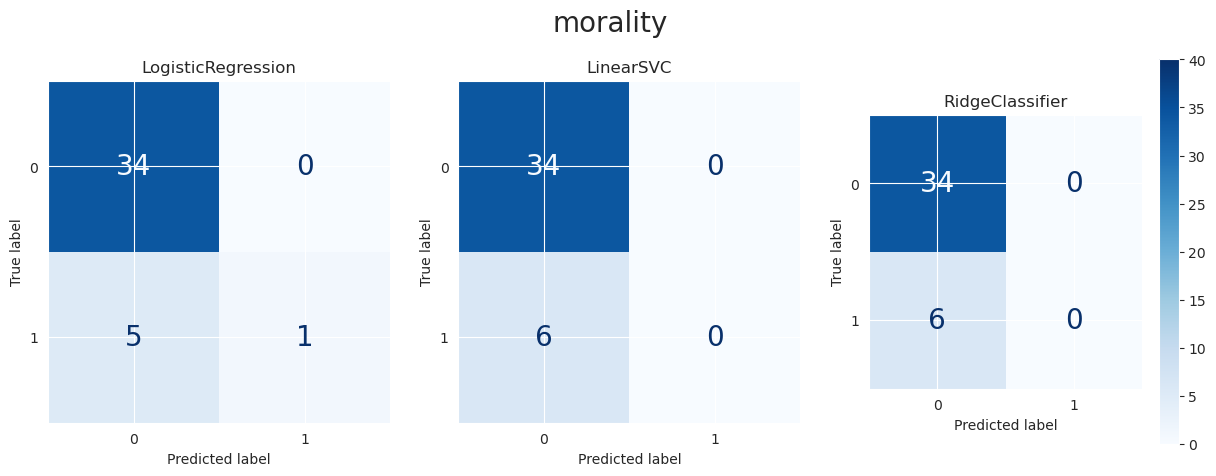

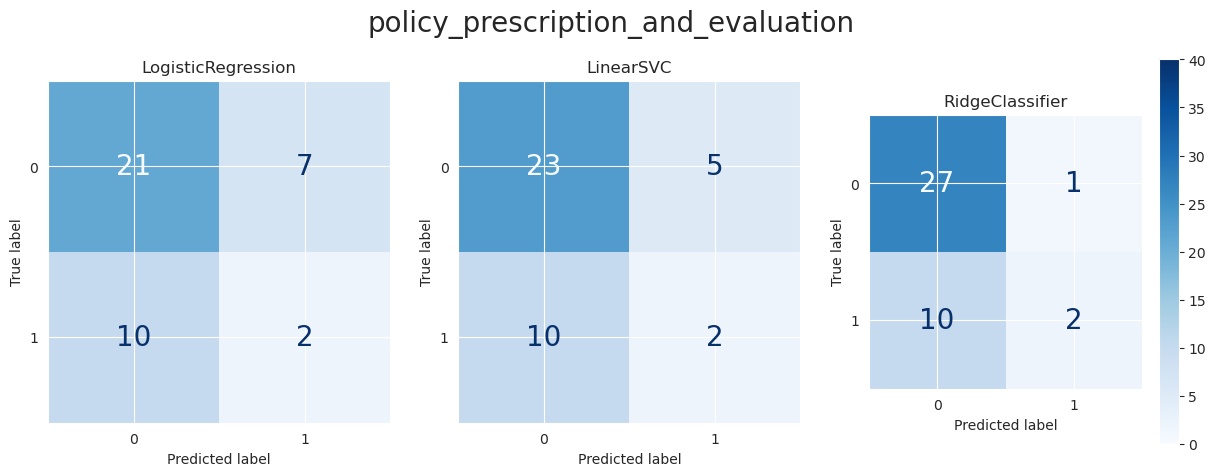

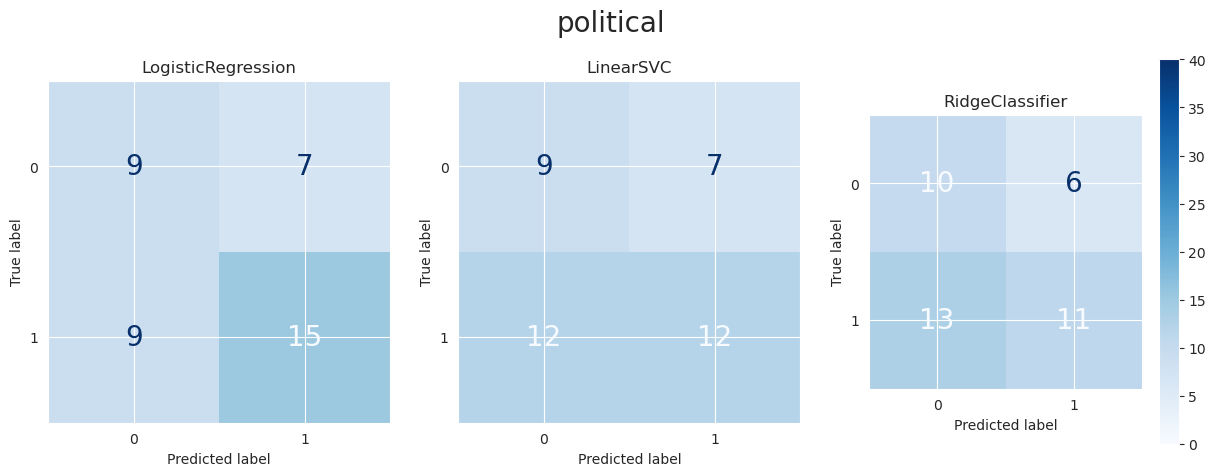

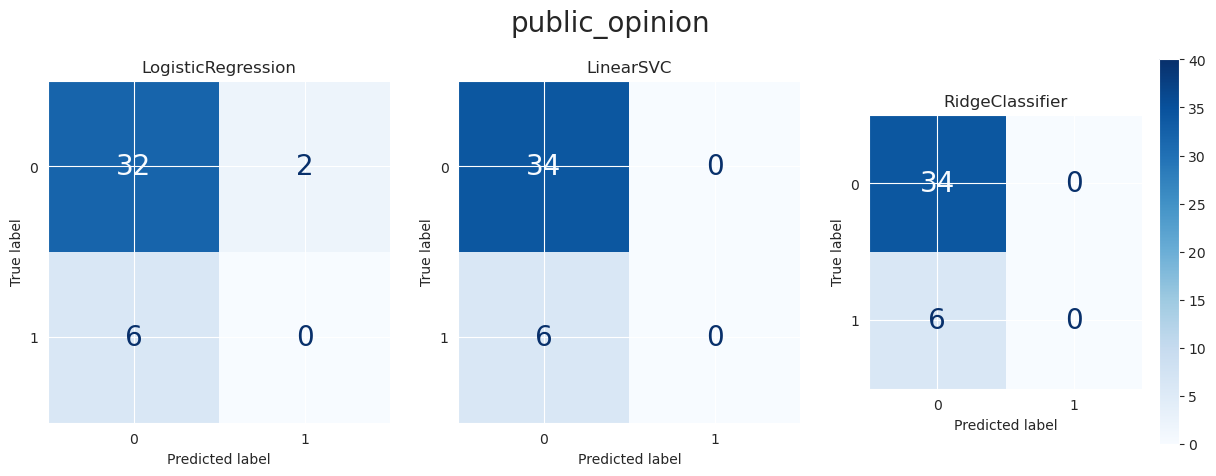

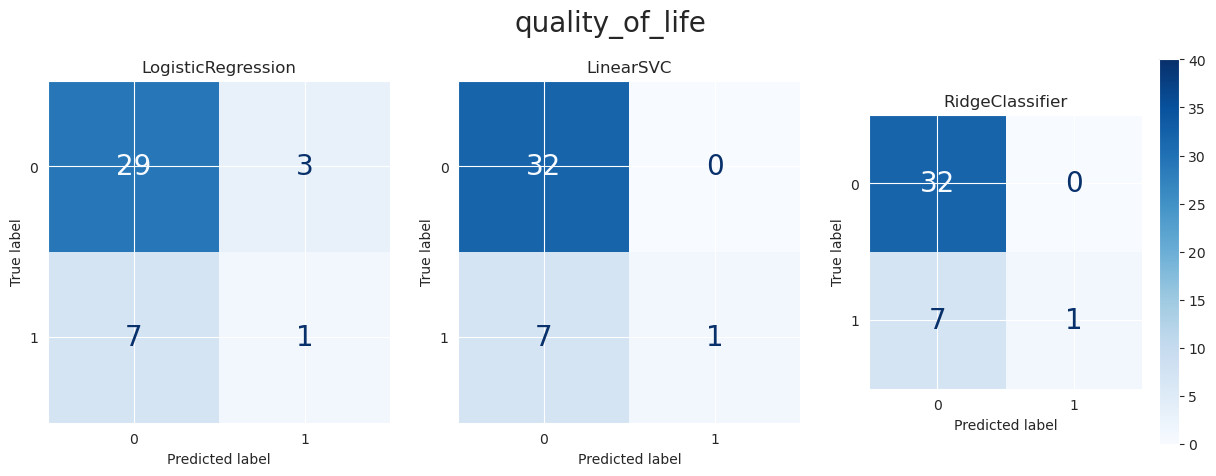

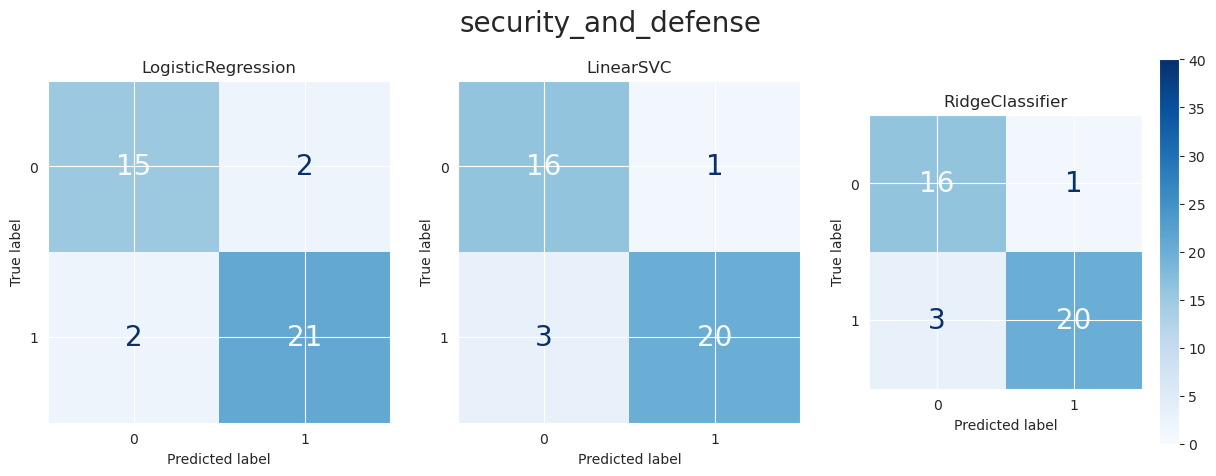

In [21]:
language = 'ge'  # ['en', 'it', 'fr', 'po', 'ru', 'ge']

plot_cms_multiple_models(
    confusion_matrices_various_models=cm_matrices_[language],
    ordered_labels=ordered_labels_,
    v_max=num_samples_test_[language],
    font_size=20,
    figsize=(15,5)
)